# Семинар. Гауссовские процессы (GP) с GPyTorch

На семинаре мы будем использовать библиотеку [GPyTorch](https://gpytorch.ai/) для моделирования GP.

In [2]:
#!pip install gpytorch

## Решение задачи регрессии с использованием гауссовских процессов
Дан набор данных $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$.  

Мы считаем, что:
$$
y = f(x) + \varepsilon,
$$
где $f(x)$ - гауссовский процесс и $\varepsilon \sim \mathcal{N}(0, \sigma_\varepsilon^2)$ - гауссовский шум.

Апостериорное распределение наблюдения $y^*$ в точке $x^*$ является гауссовским:
$$
y_* | X, \mathbf{y}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)),
$$
с средним и дисперсией, вычисляемыми по формулам:
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) + \sigma_\varepsilon^2 - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$
где
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$
$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_\varepsilon^2 \mathbf{I}
$$

## GPyTorch регрессия
Мы будем моделировать функцию:
$$
\begin{align}
y &= \sin(2\pi x) + \varepsilon \\
  \varepsilon &\sim \mathcal{N}(0, 0.04) 
\end{align}
$$

с 100 обучающими, и 51 тестовыми примерами.


In [9]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

### Определение модели

Для получения GP модели нужно сконструировать следующие GPyTorch объекты:

1. **GP Model** (`gpytorch.models.ExactGP`) -  Имеет дело с предсказаниями.
1. **Likelihood** (`gpytorch.likelihoods.GaussianLikelihood`) - Самая распостраненная функция правдоподобия.
1. **Mean** - Опредленяет априорную функцию среднего.
1. **Kernel** - Определяет ядро для получения матрицы ковариации
1. **MultivariateNormal** Distribution (`gpytorch.distributions.MultivariateNormal`) - Объект, использующийся для определения многомерного нормального распределения
  


In [14]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

### Режимы модели

Как и в большинстве PyTorch модулей, `ExactGP` имеет `.train()` и `.eval()` режимы.
- `.train()` режим для оптимизации гиперпараметров.
- `.eval()` для вычисления апостериорного распределения.

### Обучение модели

В следующей клетке максимизируется правдоподобие данных для обучения гиперпараметров гауссовского процесса



In [15]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.937   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.906   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.873   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.836   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.794   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.747   lengthscale: 0.476   noise: 0.474
Iter 7/50 - Loss: 0.697   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.645   lengthscale: 0.405   noise: 0.402
Iter 9/50 - Loss: 0.595   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.550   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.508   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.470   lengthscale: 0.291   noise: 0.284
Iter 13/50 - Loss: 0.435   lengthscale: 0.271   noise: 0.259
Iter 14/50 - Loss: 0.401   lengthscale: 0.255   noise: 0.237
Iter 15/50 - Loss: 0.368   lengthscale: 0.241   noise: 0.216
Iter 16/50 - Loss: 0.335   lengthscale: 0.231   noise: 0.196
Iter 17/50 - Loss: 0.302   length

### Предсказания с помощью модели

В следущих клетках мы получим предсказания гауссовского процесса в новых точках. Чтобы это сделать нужно перевести модель и likelihood в режим eval. и вызвать оба модуля на тестовых данных.

В режиме eval GP model возвращает `MultivariateNormal`, содержащий апостериорные среднее и дисперсии.

Если мы обозначим (`test_x`) как `x*`, истинное значение `y*`, тогда `model(test_x)` возвращает апостерирное распределение на значении функции `p(f* | x*, X, y)`, где `X, y` обучающие данные. 

Напротив, `likelihood(model(test_x))` даёт нам апостериорное предиктивное распределение `p(y* | x*, X, y)`, которое является распределением на целевое значение $y$, которое мы хотим предсказать.

Получение предиктивных дисперсии и среднего, и семплирование GP функций в новых тестовых точках может быть выполнено с помощью следующейго кода:

```python
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))
```


In [16]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

### Визуализация предсказаний


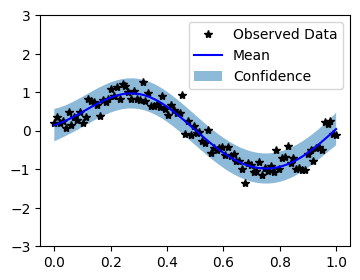

In [17]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])